---
title: Smooth trend estimation
---

We illustrate how to use the estimators $\hat{\beta}^{\text{ridge}}(\lambda)$ and $\hat{\beta}^{\text{lasso}}(\lambda)$ as well as $\hat{\mu}^{\text{ridge}}_t(\lambda)$ and $\hat{\mu}^{\text{lasso}}_t(\lambda)$ for estimating smooth trends in time series data. 

In [89]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import cvxpy as cp

We will use the following two functions (based on the python convex optimization library cvxpy) for computing the ridge and lasso estimators. 

In [90]:
#below penalty_start = 2 means that b0 and b1 are not included in the penalty
def solve_ridge(X, y, lambda_val, penalty_start=2):
    n, p = X.shape
    
    # Define variable
    beta = cp.Variable(p)
    
    # Define objective
    loss = cp.sum_squares(X @ beta - y)
    reg = lambda_val * cp.sum_squares(beta[penalty_start:])
    objective = cp.Minimize(loss + reg)
    
    # Solve problem
    prob = cp.Problem(objective)
    prob.solve()
    
    return beta.value

In [91]:
#below penalty_start = 2 means that b0 and b1 are not included in the penalty
def solve_lasso(X, y, lambda_val, penalty_start=2):
    n, p = X.shape
    
    # Define variable
    beta = cp.Variable(p)
    
    # Define objective
    loss = cp.sum_squares(X @ beta - y)
    reg = lambda_val * cp.norm1(beta[penalty_start:])
    objective = cp.Minimize(loss + reg)
    
    # Solve problem
    prob = cp.Problem(objective)
    prob.solve()
    
    return beta.value

The following dataset is from [NOAA climate at a glance](https://www.ncei.noaa.gov/access/monitoring/climate-at-a-glance/global/time-series/globe/tavg/land_ocean/1/1/1850-2025). It contains temperature anomalies for the month of January. Anomalies are in celsius and are with respect to the 1901-2000 average. 

   Year  Anomaly
0  1850    -0.46
1  1851    -0.17
2  1852    -0.02
3  1853    -0.12
4  1854    -0.28


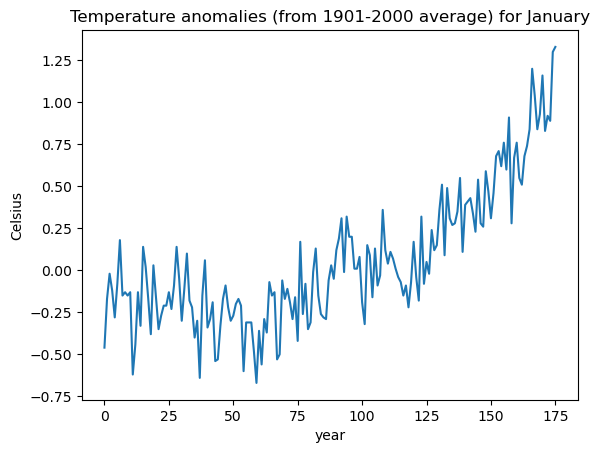

In [92]:
temp_jan = pd.read_csv('TempAnomalies_January_Feb2025.csv', skiprows=4)
print(temp_jan.head())
y = temp_jan['Anomaly']
plt.plot(y)
plt.xlabel('year')
plt.ylabel('Celsius')
plt.title('Temperature anomalies (from 1901-2000 average) for January')
plt.show()

The $X$ matrix in the representation $y = X \beta + \epsilon$ of this model is constructed as follows. 

In [93]:
n = len(y)
x = np.arange(1, n+1)
Xfull = np.column_stack([np.ones(n), x-1])
for i in range(n-2):
    c = i+2
    xc = ((x > c).astype(float))*(x-c)
    Xfull = np.column_stack([Xfull, xc])
print(Xfull)

[[  1.   0.  -0. ...  -0.  -0.  -0.]
 [  1.   1.   0. ...  -0.  -0.  -0.]
 [  1.   2.   1. ...  -0.  -0.  -0.]
 ...
 [  1. 173. 172. ...   1.   0.  -0.]
 [  1. 174. 173. ...   2.   1.   0.]
 [  1. 175. 174. ...   3.   2.   1.]]


The ridge regression estimate is computed below. Start with some standard choice of $\lambda$ (e.g., $\lambda = 1$) and then increase or decrease it by factors of 10 until you get a fit that is visually nice (smooth while capturing patterns in the data).

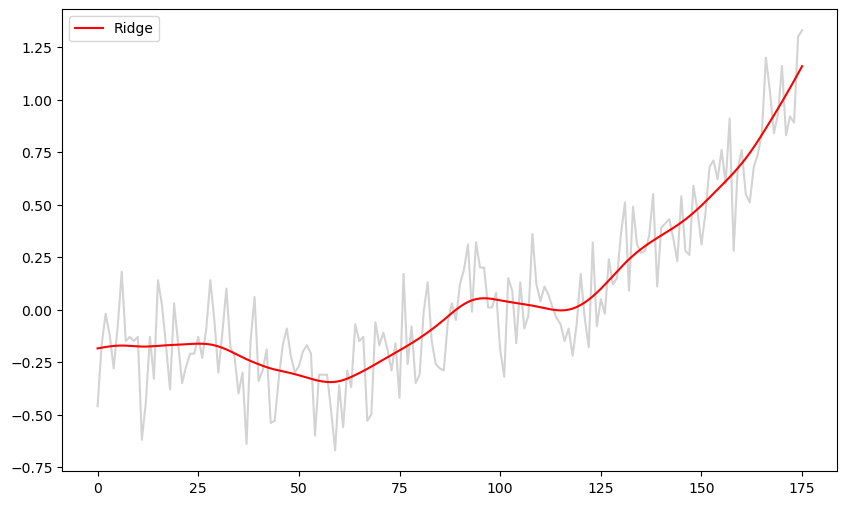

In [96]:
b_ridge = solve_ridge(Xfull, y, lambda_val = 1000)
ridge_fitted = np.dot(Xfull, b_ridge)
plt.figure(figsize = (10, 6))
plt.plot(y, color = 'lightgray')
plt.plot(ridge_fitted, color = 'red', label = 'Ridge')
plt.legend()
plt.show()

The code for LASSO is given below. Start with some standard choice of $\lambda$ (e.g., $\lambda = 1$) and then increase or decrease it by factors of 10 until you get a fit that is visually nice.

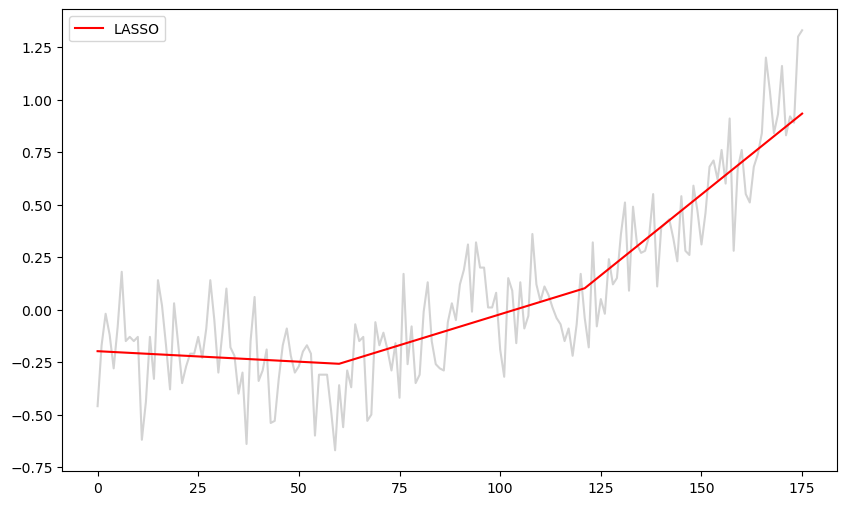

In [97]:
b_lasso = solve_lasso(Xfull, y, lambda_val = 100)
lasso_fitted = np.dot(Xfull, b_lasso)
plt.figure(figsize = (10, 6))
plt.plot(y, color = 'lightgray')
plt.plot(lasso_fitted, color = 'red', label = 'LASSO')
plt.legend()
plt.show()

Note that the LASSO fit is piecewise linear while the ridge fit is more smoother (without any kinks).

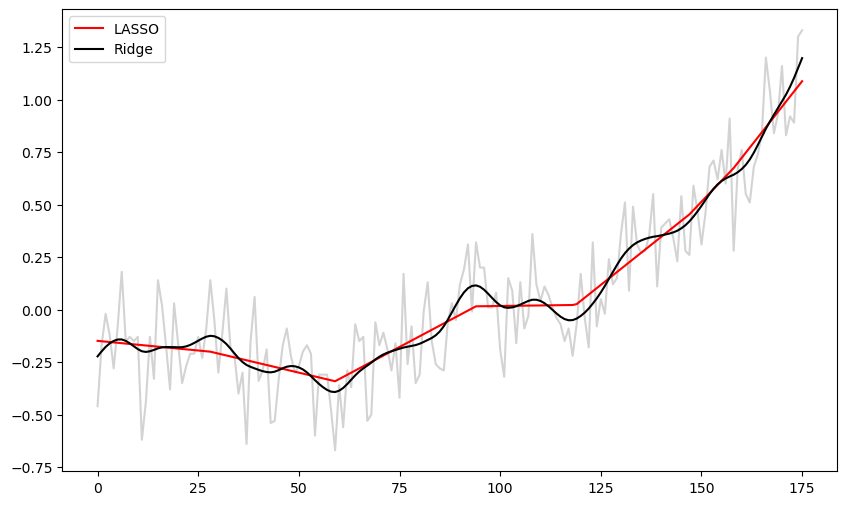

In [308]:
b_ridge = solve_ridge(Xfull, y, lambda_val = 100)
ridge_fitted = np.dot(Xfull, b_ridge)

b_lasso = solve_lasso(Xfull, y, lambda_val = 10)
lasso_fitted = np.dot(Xfull, b_lasso)

plt.figure(figsize=(10, 6))
plt.plot(y, color = 'lightgray')
#plt.plot(y, color = 'None')
plt.plot(lasso_fitted, color = 'red', label = 'LASSO')
plt.plot(ridge_fitted, color = 'black', label = "Ridge")
plt.legend()
plt.show()

We compare the ridge estimates for $\beta$ with unregularized estimates (which correspond to $\lambda = 0$) below.

0.28999999999997206 0.08093800016168097
-0.4599999999999922 -0.31625538257232577


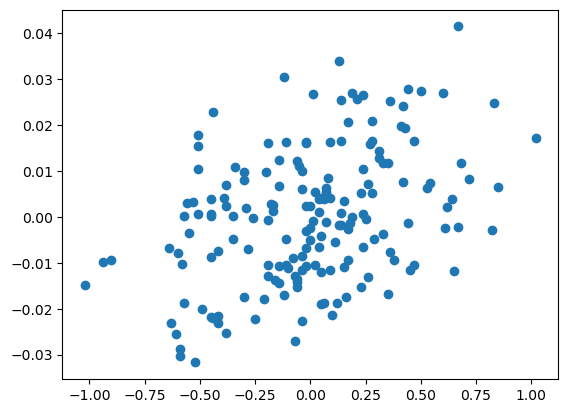

In [301]:
b_ridge_0 = solve_ridge(Xfull, y, lambda_val = 0)
b_ridge = solve_ridge(Xfull, y, lambda_val = 10)
plt.scatter(b_ridge_0[2:], b_ridge[2:])
print(b_ridge_0[1], b_ridge[1])
print(b_ridge_0[0], b_ridge[0])

Note that the $y$-axis has a much tighter range compared to the $x$-axis. This illustrates the shrinkage aspect of ridge regression. 

Below we compare the LASSO estimates with the unregularized MLE (which corresponds to $\lambda = 0$). 

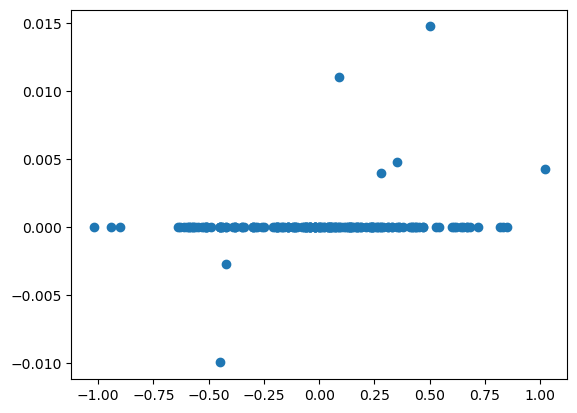

0.290000000000026 -0.0018357831169318211
-0.4599999999999873 -0.14899519332692415


In [302]:
b_lasso_0 = solve_lasso(Xfull, y, lambda_val = 0)
b_lasso = solve_lasso(Xfull, y, lambda_val = 10)
plt.scatter(b_lasso_0[2:], b_lasso[2:])
plt.show()
print(b_lasso_0[1], b_lasso[1])
print(b_lasso_0[0], b_lasso[0])

This plot clearly shows that the LASSO sets most coefficients exactly to zero. Compare this plot to the corresponding plot for the ridge estimator. 

The following code implements cross validation for selecting $\lambda$ in ridge regression. 

In [98]:
def ridge_cv(X, y, lambda_candidates):
    n = len(y)
    folds = []
    for i in range(5):
        test_indices = np.arange(i, n, 5)
        train_indices = np.array([j for j in range(n) if j % 5 != i])
        folds.append((train_indices, test_indices))
    cv_errors = {lamb: 0 for lamb in lambda_candidates}

    for train_index, test_index in folds:
        X_train = X[train_index]
        X_test = X[test_index]
        y_train = y[train_index]
        y_test = y[test_index]

        for lamb in lambda_candidates:
            beta = solve_ridge(X_train, y_train, lambda_val = lamb)
            y_pred = np.dot(X_test, beta)
            squared_errors = (y_test - y_pred) ** 2
            cv_errors[lamb] += np.sum(squared_errors)
    for lamb in lambda_candidates:
        cv_errors[lamb] /= n
        
    best_lambda = min(cv_errors, key = cv_errors.get)

    return best_lambda, cv_errors

In [99]:
lambda_candidates = np.array([0.1, 1, 10, 100, 1000, 10000, 100000])
print(lambda_candidates)

best_lambda, cv_errors = ridge_cv(Xfull, y, lambda_candidates)
print(best_lambda)
print("CV errors for each lambda:")
for lamb, error in sorted(cv_errors.items()):
    print(f"Lambda = {lamb:.2f}, CV Error = {error:.6f}")


[1.e-01 1.e+00 1.e+01 1.e+02 1.e+03 1.e+04 1.e+05]
100.0
CV errors for each lambda:
Lambda = 0.10, CV Error = 0.038557
Lambda = 1.00, CV Error = 0.034160
Lambda = 10.00, CV Error = 0.030811
Lambda = 100.00, CV Error = 0.030621
Lambda = 1000.00, CV Error = 0.030640
Lambda = 10000.00, CV Error = 0.031044
Lambda = 100000.00, CV Error = 0.033401


The following code illustrated cross validation for selecting $\lambda$ in LASSO. 

In [100]:
def lasso_cv(X, y, lambda_candidates):
    n = len(y)
    folds = []
    for i in range(5):
        test_indices = np.arange(i, n, 5)
        train_indices = np.array([j for j in range(n) if j % 5 != i])
        folds.append((train_indices, test_indices))
    cv_errors = {lamb: 0 for lamb in lambda_candidates}

    for train_index, test_index in folds:
        X_train = X[train_index]
        X_test = X[test_index]
        y_train = y[train_index]
        y_test = y[test_index]

        for lamb in lambda_candidates:
            beta = solve_lasso(X_train, y_train, lambda_val = lamb)
            y_pred = np.dot(X_test, beta)
            squared_errors = (y_test - y_pred) ** 2
            cv_errors[lamb] += np.sum(squared_errors)
    for lamb in lambda_candidates:
        cv_errors[lamb] /= n
        
    best_lambda = min(cv_errors, key = cv_errors.get)

    return best_lambda, cv_errors

In [101]:
lambda_candidates = np.array([0.1, 1, 10, 100, 1000, 10000, 100000])
print(lambda_candidates)

best_lambda, cv_errors = lasso_cv(Xfull, y, lambda_candidates)
print(best_lambda)
print("CV errors for each lambda:")
for lamb, error in sorted(cv_errors.items()):
    print(f"Lambda = {lamb:.2f}, CV Error = {error:.6f}")


[1.e-01 1.e+00 1.e+01 1.e+02 1.e+03 1.e+04 1.e+05]
10.0
CV errors for each lambda:
Lambda = 0.10, CV Error = 0.034315
Lambda = 1.00, CV Error = 0.031163
Lambda = 10.00, CV Error = 0.030645
Lambda = 100.00, CV Error = 0.034554
Lambda = 1000.00, CV Error = 0.066568
Lambda = 10000.00, CV Error = 0.066568
Lambda = 100000.00, CV Error = 0.066568


Next we consider a simulated dataset that is obtained by adding noise to a smooth trend function. 

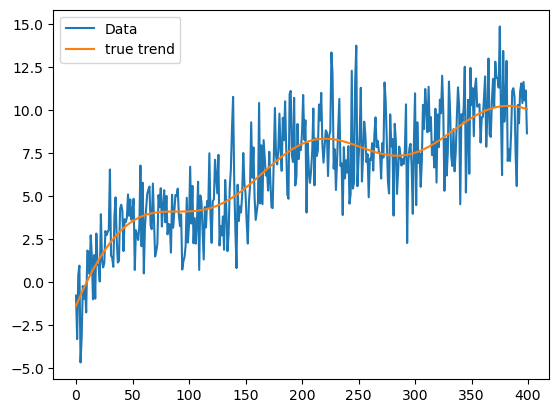

In [116]:
def smoothfun(x):
    ans = np.sin(15*x) + 3*np.exp(-(x ** 2)/2) + 0.5*((x - 0.5) ** 2) + 5 * np.log(x + 0.1) + 7
    return ans

n = 400
xx = np.linspace(0, 1, 400)
truth = np.array([smoothfun(x) for x in xx])

sig = 2
rng = np.random.default_rng(seed = 42)
errorsamples = rng.normal(loc=0, scale = sig, size = n)
y = truth + errorsamples

plt.plot(y, label = 'Data')
plt.plot(truth, label = 'true trend')
plt.legend()
plt.show()

In [117]:
n = len(y)
x = np.arange(1, n+1)
Xfull = np.column_stack([np.ones(n), x-1])
for i in range(n-2):
    c = i+2
    xc = ((x > c).astype(float))*(x-c)
    Xfull = np.column_stack([Xfull, xc])
print(Xfull)

[[  1.   0.  -0. ...  -0.  -0.  -0.]
 [  1.   1.   0. ...  -0.  -0.  -0.]
 [  1.   2.   1. ...  -0.  -0.  -0.]
 ...
 [  1. 397. 396. ...   1.   0.  -0.]
 [  1. 398. 397. ...   2.   1.   0.]
 [  1. 399. 398. ...   3.   2.   1.]]


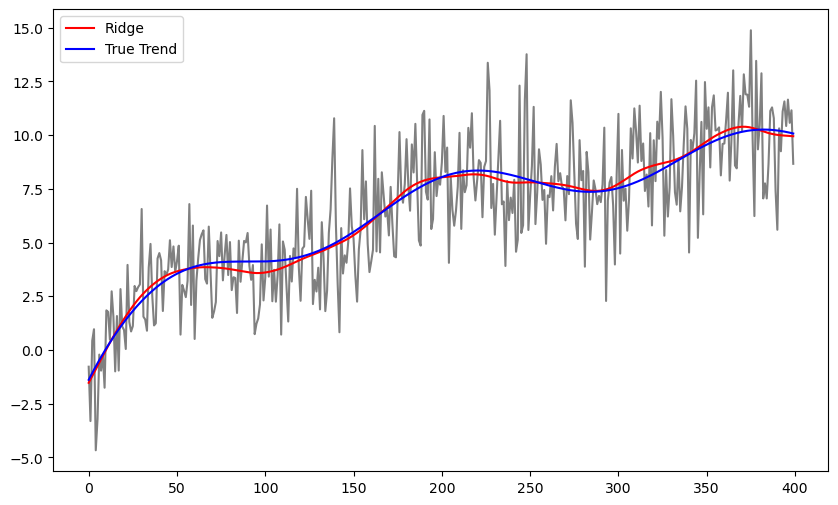

In [122]:
b_ridge = solve_ridge(Xfull, y, lambda_val = 10000)
ridge_fitted = np.dot(Xfull, b_ridge)
plt.figure(figsize = (10, 6))
plt.plot(y, color = 'gray')
plt.plot(ridge_fitted, color = 'red', label = 'Ridge')
plt.plot(truth, color = 'blue', label = "True Trend")
plt.legend()
plt.show()

In [123]:
lambda_candidates = np.array([10, 100, 1000, 10000, 100000, 1000000])
best_lambda, cv_errors = ridge_cv(Xfull, y, lambda_candidates)
print(best_lambda)
print("CV errors for each lambda:")
for lamb, error in sorted(cv_errors.items()):
    print(f"Lambda = {lamb:.2f}, CV Error = {error:.6f}")


100000
CV errors for each lambda:
Lambda = 10.00, CV Error = 4.221263
Lambda = 100.00, CV Error = 4.052517
Lambda = 1000.00, CV Error = 3.894083
Lambda = 10000.00, CV Error = 3.791721
Lambda = 100000.00, CV Error = 3.771729
Lambda = 1000000.00, CV Error = 3.970162


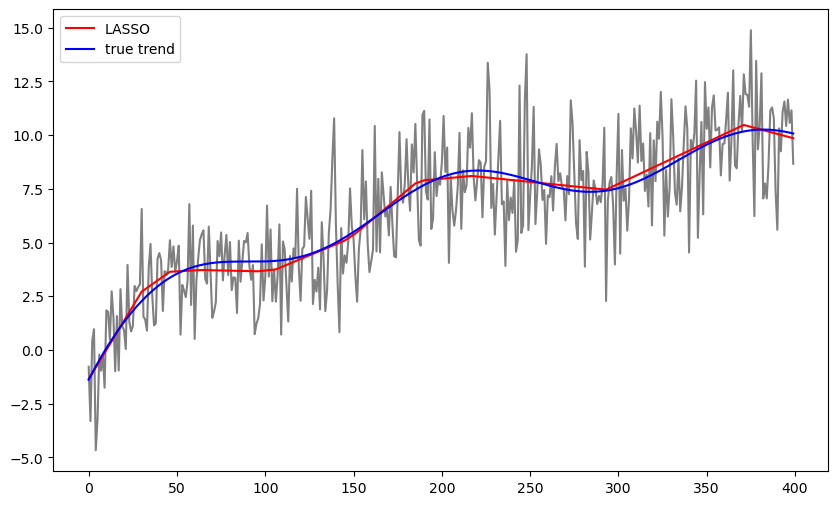

In [125]:
b_lasso = solve_lasso(Xfull, y, lambda_val = 100)
lasso_fitted = np.dot(Xfull, b_lasso)
plt.figure(figsize = (10, 6))
plt.plot(y, color = 'gray')
plt.plot(lasso_fitted, color = 'red', label = 'LASSO')
plt.plot(truth, color = 'blue', label = "true trend")
plt.legend()
plt.show()

In [126]:
lambda_candidates = np.array([1, 10, 100, 1000, 10000])
best_lambda, cv_errors = lasso_cv(Xfull, y, lambda_candidates)
print(best_lambda)
print("CV errors for each lambda:")
for lamb, error in sorted(cv_errors.items()):
    print(f"Lambda = {lamb:.3f}, CV Error = {error:.6f}")

100
CV errors for each lambda:
Lambda = 1.000, CV Error = 4.596651
Lambda = 10.000, CV Error = 4.084715
Lambda = 100.000, CV Error = 3.809634
Lambda = 1000.000, CV Error = 4.027127
Lambda = 10000.000, CV Error = 4.378784


The following code considers simulated data from a piecewise linear trend function corrupted with noise.

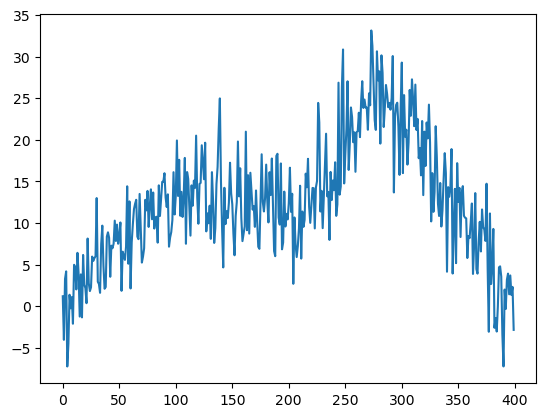

In [127]:
def piece_linear(x):
    ans = np.zeros_like(x, dtype=float)
    
    # First segment: 0 <= x <= 0.25
    mask1 = (x >= 0) & (x <= 0.25)
    ans[mask1] = (14.77491 / 0.25) * x[mask1]
    
    # Second segment: 0.25 < x <= 0.525
    mask2 = (x > 0.25) & (x <= 0.525)
    ans[mask2] = (10.71181 + ((10.71181 - 14.77491) / (0.525 - 0.25)) * (x[mask2] - 0.525))
    
    # Third segment: 0.525 < x <= 0.705
    mask3 = (x > 0.525) & (x <= 0.705)
    ans[mask3] = (26.59484 + ((26.59584 - 10.71181) / (0.705 - 0.525)) * (x[mask3] - 0.705))
    
    # Fourth segment: 0.705 < x <= 1
    mask4 = (x > 0.705) & (x <= 1)
    ans[mask4] = ((0 - 26.59584) / (1 - 0.705)) * (x[mask4] - 1)
    
    return ans

n = 400
xx = np.linspace(0, 1, 400)
truth = piece_linear(xx)

sig = 4
rng = np.random.default_rng(seed = 42)
errorsamples = rng.normal(loc=0, scale = sig, size = n)
y = truth + errorsamples
plt.plot(y)
plt.show()

In [128]:
n = len(y)
x = np.arange(1, n+1)
Xfull = np.column_stack([np.ones(n), x-1])
for i in range(n-2):
    c = i+2
    xc = ((x > c).astype(float))*(x-c)
    Xfull = np.column_stack([Xfull, xc])
print(Xfull)

[[  1.   0.  -0. ...  -0.  -0.  -0.]
 [  1.   1.   0. ...  -0.  -0.  -0.]
 [  1.   2.   1. ...  -0.  -0.  -0.]
 ...
 [  1. 397. 396. ...   1.   0.  -0.]
 [  1. 398. 397. ...   2.   1.   0.]
 [  1. 399. 398. ...   3.   2.   1.]]


In [129]:
lambda_candidates = np.array([1000, 10000, 100000, 1000000])
best_lambda, cv_errors = ridge_cv(Xfull, y, lambda_candidates)
print(best_lambda)
print("CV errors for each lambda:")
for lamb, error in sorted(cv_errors.items()):
    print(f"Lambda = {lamb:.2f}, CV Error = {error:.6f}")


10000
CV errors for each lambda:
Lambda = 1000.00, CV Error = 15.604092
Lambda = 10000.00, CV Error = 15.223786
Lambda = 100000.00, CV Error = 15.340427
Lambda = 1000000.00, CV Error = 18.374224


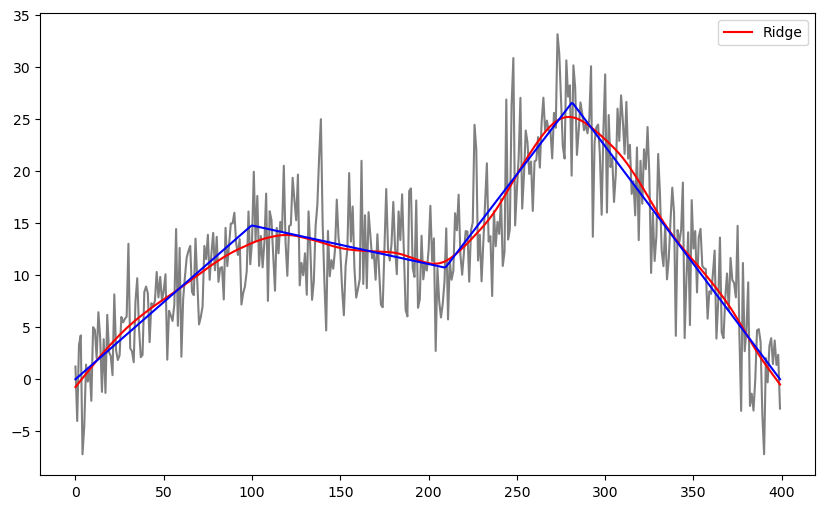

In [130]:
b_ridge = solve_ridge(Xfull, y, lambda_val = 10000)
ridge_fitted = np.dot(Xfull, b_ridge)
plt.figure(figsize = (10, 6))
plt.plot(y, color = 'gray')
plt.plot(ridge_fitted, color = 'red', label = 'Ridge')
plt.plot(truth, color = 'blue')
plt.legend()
plt.show()

In [131]:
lambda_candidates = np.array([1, 10, 100, 1000, 10000])
best_lambda, cv_errors = lasso_cv(Xfull, y, lambda_candidates)
print(best_lambda)
print("CV errors for each lambda:")
for lamb, error in sorted(cv_errors.items()):
    print(f"Lambda = {lamb:.3f}, CV Error = {error:.6f}")

1000
CV errors for each lambda:
Lambda = 1.000, CV Error = 19.302664
Lambda = 10.000, CV Error = 16.938073
Lambda = 100.000, CV Error = 15.228507
Lambda = 1000.000, CV Error = 15.180670
Lambda = 10000.000, CV Error = 22.089595


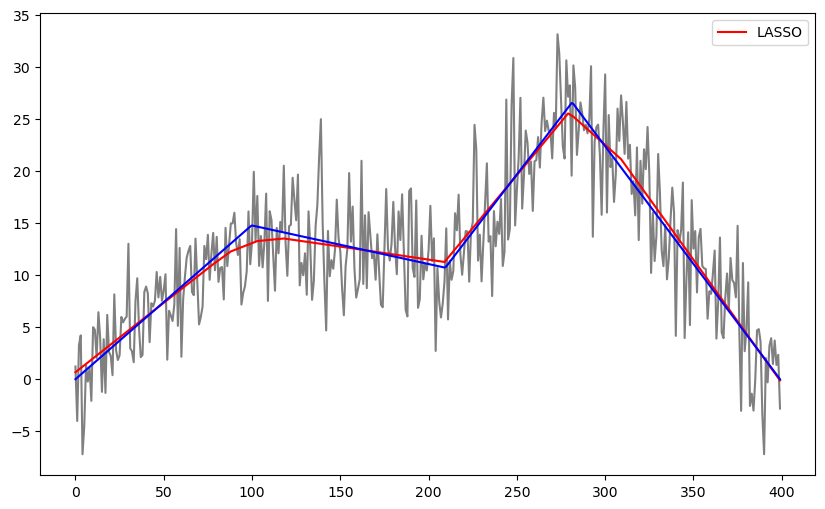

In [132]:
b_lasso = solve_lasso(Xfull, y, lambda_val = 1000)
lasso_fitted = np.dot(Xfull, b_lasso)
plt.figure(figsize = (10, 6))
plt.plot(y, color = 'gray')
plt.plot(lasso_fitted, color = 'red', label = 'LASSO')
plt.plot(truth, color = 'blue')
plt.legend()
plt.show()

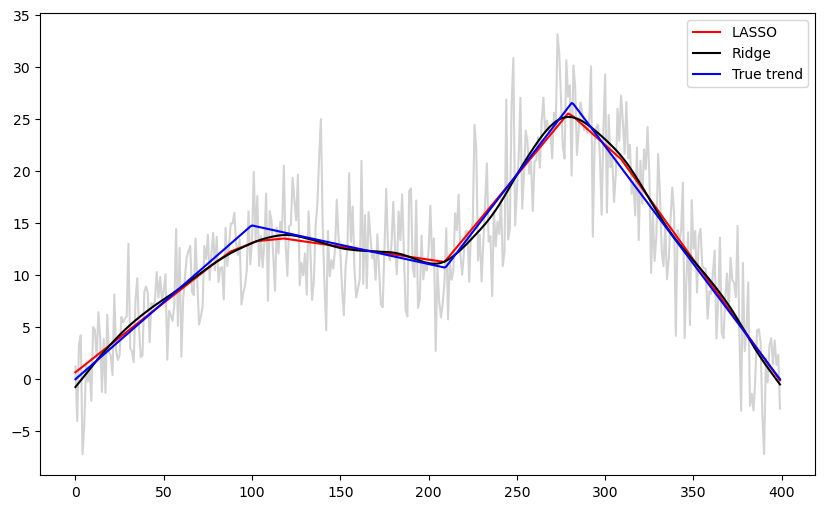

In [134]:
b_ridge = solve_ridge(Xfull, y, lambda_val = 10000)
ridge_fitted = np.dot(Xfull, b_ridge)

b_lasso = solve_lasso(Xfull, y, lambda_val = 1000)
lasso_fitted = np.dot(Xfull, b_lasso)

plt.figure(figsize=(10, 6))
plt.plot(y, color = 'lightgray')
#plt.plot(y, color = 'None')
plt.plot(lasso_fitted, color = 'red', label = 'LASSO')
plt.plot(ridge_fitted, color = 'black', label = "Ridge")
plt.plot(truth, color = 'blue', label = 'True trend')
plt.legend()
plt.show()